In [1]:
import gEconpy as ge
import gEconpy.plotting as gp
import numpy as np

In [2]:
mod_cd = ge.model_from_gcn(
    "../GCN Files/RBC_steady_state.gcn", backend="pytensor", mode="JAX"
)

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		P_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [3]:
mod = ge.model_from_gcn("../GCN Files/RBC_with_CES.gcn", backend="pytensor", mode="JAX")

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	8 parameters
		 0 / 8 has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [4]:
mod_cd.steady_state()

{'A_ss': 1.0,
 'C_ss': 2.358436140751452,
 'I_ss': 0.7146463688416047,
 'K_ss': 35.73231844208024,
 'L_ss': 0.8200691321870384,
 'Y_ss': 3.073082509593057,
 'lambda_ss': 0.27609835425625046,
 'r_ss': 0.030101010101010184,
 'w_ss': 2.435774683907873}

In [5]:
mod.steady_state(psi=0.005)

{'A_ss': 1.0,
 'C_ss': 1.4389108598561584,
 'I_ss': 0.010323902094788425,
 'K_ss': 0.5161951047394212,
 'L_ss': 0.9400165290743415,
 'Y_ss': 1.449234761950947,
 'lambda_ss': 0.5793608764729975,
 'r_ss': 0.030101010101010184,
 'w_ss': 1.5251825085468236}

In [6]:
psis = np.linspace(1e-4, 0.99, 100)
res = []
for i, psi in enumerate(psis):
    ss = mod.steady_state(psi=psi)
    ss["success"] = ss.success
    res.append(ss)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(res, index=psis)

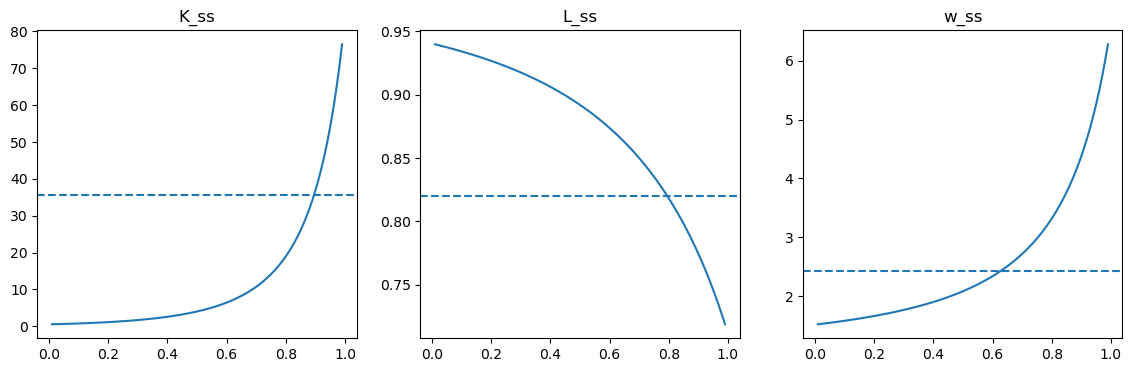

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, var in enumerate(["K_ss", "L_ss", "w_ss"]):
    df.plot.line(y=var, ax=ax[i], legend=False)
    ax[i].set_title(var)
    ax[i].axhline(mod_cd.steady_state()[var], ls="--")